# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


# Function that sets up HNC QSP 

### Create and run plasma

In [2]:
Z, A = 6 , 12
mi = m_p * A
ρ_gpercc = 2.267
ni_cc = ρ_gpercc/(mi*AU_to_g)
ri_cm = rs_from_n(ni_cc)
ri_AU = ri_cm*cm_to_AU

Te_eV = 5
Ti_eV = 5

ri_AU

2.4239185975523876

### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

In [4]:
from scipy.integrate import simpson

bound_file = "../data/C_ri_2.424_T5.0eV.csv"
AA_data = read_csv(bound_file, delim_whitespace=True, header=0)
AA_r_AU_full = np.array(AA_data['r[a_0]'])
AA_nb_AU_full = np.array(AA_data['n[bound]'])

# Get Zbar
Zbar = Z - simpson(4*π*AA_nb_AU_full*AA_r_AU_full**2,  AA_r_AU_full)
print(f"Total Zbar from integration: {Zbar:.3f}")


Total Zbar from integration: 4.000


In [5]:
atom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':0, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'alpha_Picard':0.1},
                 root_options={'options':{'maxfev':50000,'xtol':1e-14}})

Te_in_eV: 5.000
Ti_in_eV: 5.000


(0.0, 6.194495172852935)

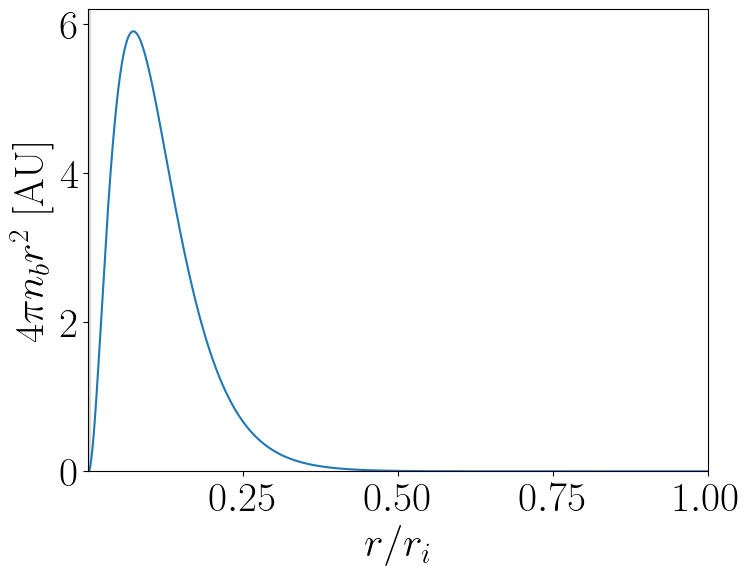

In [6]:
# Only use some values for speed
min_r_to_use = 0.2*atom.hnc.r_array[0]*atom.qsp.ri # in AU
indcs = np.where(AA_r_AU_full > min_r_to_use)
AA_r_AU = AA_r_AU_full[indcs]
AA_nb_AU = AA_nb_AU_full[indcs]


# Plot bound states
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(AA_r_AU_full/atom.qsp.ri, 4*π*AA_nb_AU_full*AA_r_AU_full**2)
ax.axvspan(AA_r_AU_full[0]/atom.qsp.ri, min_r_to_use/atom.qsp.ri, color='k', alpha=0.1)
ax.set_xlabel(r'$r/r_i$')
ax.set_ylabel(r'$4 \pi n_b r^2$ [AU]')
# ax.set_xscale('log')
ax.set_xlim(np.min(AA_r_AU_full/atom.qsp.ri), np.max(AA_r_AU_full/atom.qsp.ri))
ax.set_ylim(0, None)

[-1, 1, 0.0020014913062257455, 1.0000001660318196]


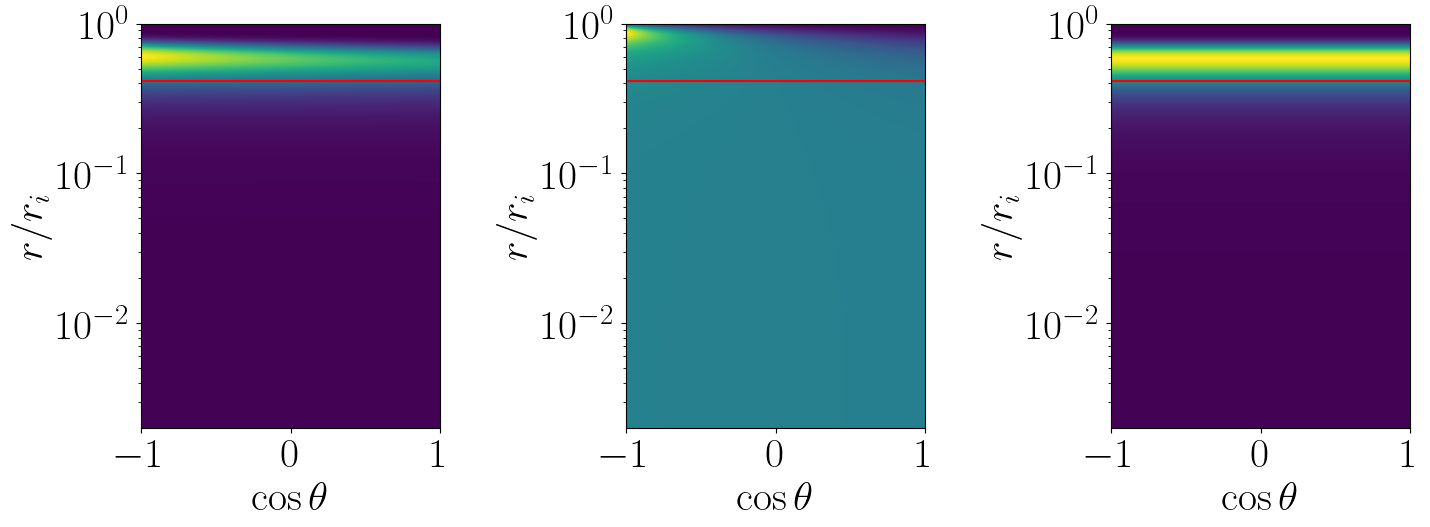

0.7533305352365024

In [7]:
from scipy.integrate import dblquad, simpson
from scipy.interpolate import RegularGridInterpolator

def new_δβuei(r_sep_in_AU, verbose = False, only_Pauli=True, HNC_Pauli=True):
    r_array = AA_r_AU #AU
    rs = atom.qsp.ri
    cosφ_array = np.linspace(-1,1,num=100)
    r_mesh, cosφ_mesh = np.meshgrid(r_array,cosφ_array, indexing='ij')

    nb_mesh = AA_nb_AU[:,np.newaxis] * np.ones_like(r_mesh)
    ree_mesh = np.sqrt( r_sep_in_AU**2 + r_mesh**2 + 2*r_mesh*r_sep_in_AU*cosφ_mesh  )
    
    if only_Pauli:
        # βu_ee_mesh = atom.qsp.βv_Pauli(ree_mesh/rs, atom.qsp.Λee)
        if HNC_Pauli:
            βu_ee_mesh = atom.βP_ee_func(ree_mesh/rs)
        else:
            βu_ee_mesh = atom.qsp.βv_Pauli(ree_mesh/rs, type='Lado')
    else:
        βu_ee_mesh = atom.qsp.βvee( ree_mesh/rs  ) + atom.βP_ee_func(ree_mesh/rs) - atom.qsp.βv_Pauli(ree_mesh/rs)
    
    integrand_mesh = 2*π* r_mesh**2 * nb_mesh*βu_ee_mesh
    
    if verbose:
        fig, axs = plt.subplots(1,3)
        extent = [-1,1, r_array[0]/atom.qsp.ri, r_array[-1]/atom.qsp.ri]
        print(extent)
        axs[0].imshow(r_mesh**2 * nb_mesh*βu_ee_mesh, origin='lower', extent=extent)
        axs[1].imshow(βu_ee_mesh, origin='lower', extent=extent)
        axs[2].imshow(r_mesh**2 * nb_mesh, origin='lower', extent=extent)
        for ax in axs:
            ax.set_ylabel(r'$r/r_i$')
            ax.set_xlabel(r'$\cos \theta$')
            ax.set_yscale('log')
            ax.plot(cosφ_array, np.ones_like(cosφ_array) * r_sep_in_AU/atom.qsp.ri ,'r')

        plt.tight_layout()
        plt.show()
    δβuei_simpson = simpson(simpson(integrand_mesh, axis=0, x=r_array), axis=0, x=cosφ_array)
    
#     δβuei_interp = RegularGridInterpolator( (r_array, cosφ_array), integrand_mesh  )
#     δβuei_integrand = lambda y, x : δβuei_interp((x, y)) # Weird convention, flipping not a mistake...
#     δβuei = dblquad(δβuei_integrand, r_array[0], r_array[-1], -1, 1)
    
    return δβuei_simpson#, δβuei
    
new_δβuei(1, verbose=True, HNC_Pauli=False)

In [8]:
δβuei = np.array([new_δβuei(r_hnc*atom.qsp.ri, only_Pauli=False) for r_hnc in atom.hnc.r_array])
δβuei_Pauli_HNC = np.array([new_δβuei(r_hnc*atom.qsp.ri) for r_hnc in atom.hnc.r_array])
δβuei_Pauli_Lado = np.array([new_δβuei(r_hnc*atom.qsp.ri, HNC_Pauli=False) for r_hnc in atom.hnc.r_array])

(-10000.0, 100.0)

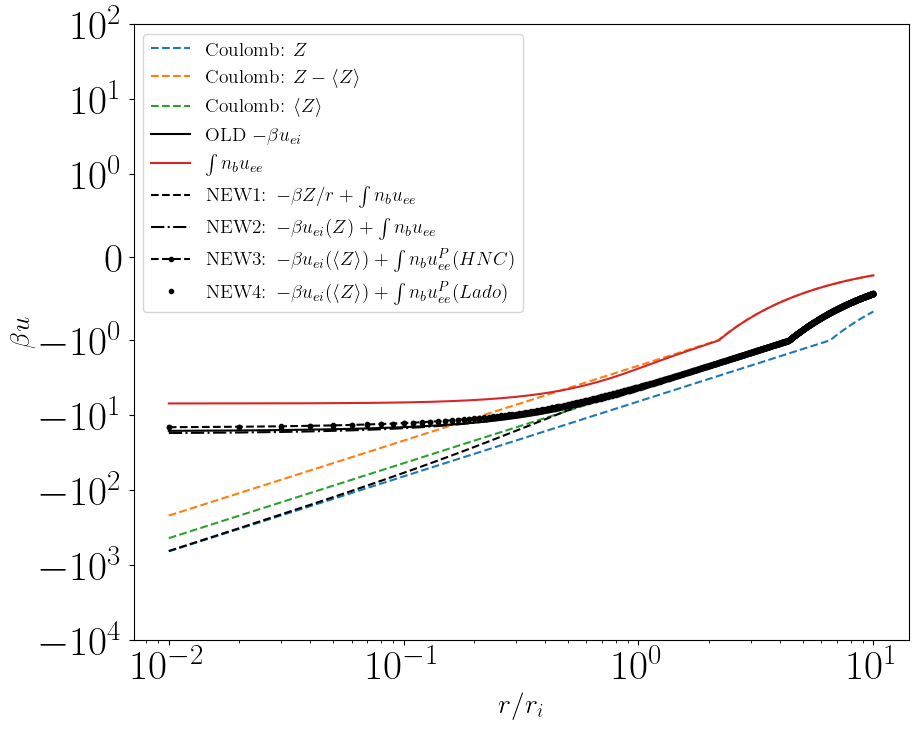

In [9]:
fig, ax = plt.subplots(figsize=(10,8))


ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * Z/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $ Z$')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * (Z-Zbar)/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $ Z-\langle Z \rangle$')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * Zbar/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $\langle Z \rangle$')
ax.plot(atom.hnc.r_array, atom.hnc.βu_r_matrix[0,1], 'k-',label=r'OLD $-\beta u_{ei}$')
ax.plot(atom.hnc.r_array, -δβuei, label=r' $\int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1]* Z/(atom.hnc.r_array*atom.qsp.ri) + δβuei,'k--' , label=r' NEW1: $-\beta Z/r + \int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array,  Z/Zbar*atom.hnc.βu_r_matrix[0,1] + δβuei,'k-.' , label=r' NEW2: $-\beta u_{ei}(Z) + \int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array,  atom.hnc.βu_r_matrix[0,1] + δβuei_Pauli_HNC,'k--.' , label=r' NEW3: $-\beta u_{ei}(\langle Z \rangle) + \int n_b u^P_{ee}(HNC)$ ')
ax.plot(atom.hnc.r_array,  atom.hnc.βu_r_matrix[0,1] + δβuei_Pauli_Lado,'k.' , label=r' NEW4: $-\beta u_{ei}(\langle Z \rangle) + \int n_b u^P_{ee}(Lado)$ ')

ax.legend(fontsize=14)
ax.set_yscale('symlog', linthresh=1)
ax.set_xscale('log')

ax.set_ylabel(r"$\beta u$", fontsize=20)
ax.set_xlabel(r"$r/r_i$", fontsize=20)

ax.set_ylim(-1e4,1e2)

### Solving

In [13]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnc11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnc11
    return hnc_matrix

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None, ftol=1e-8):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='linear')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)
    
def best_shift(plasma, guess_c_s_k, ftol=1e-8, set=True):
    
    
    def min_function(multiplier_list):
        xii, xei, xee = multiplier_list
        multiplier_matrix = np.array([[xii,xei],[xei,xee]])
        c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        
        return c_s_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    sol = least_squares(min_function, np.ones((3)) , verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    xii, xei, xee = sol.x
    multiplier_matrix = np.array([[xii,xei],[xei,xee]])
    
    plasma.hnc.c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
    print(sol)
    return sol

In [14]:
atom1 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, 
                 βu_options = {'add_bridge':False,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.01},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})

atom2 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.01, 'verbose':True},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})

atom3 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,find_βuee=False, 
                 βu_options = {'add_bridge':False,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.01,'verbose':False},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})


atom1.hnc.βu_r_matrix[0,1] = atom1.hnc.βu_r_matrix[0,1] + δβuei_Pauli_Lado
atom1.hnc.βu_r_matrix[1,0] = atom1.hnc.βu_r_matrix[1,0] + δβuei_Pauli_Lado
atom1.hnc.set_βu_matrix(atom1.hnc.βu_r_matrix)

atom2.hnc.βu_r_matrix[0,1] = atom2.hnc.βu_r_matrix[0,1] + δβuei_Pauli_HNC
atom2.hnc.βu_r_matrix[1,0] = atom2.hnc.βu_r_matrix[1,0] + δβuei_Pauli_HNC
atom2.hnc.set_βu_matrix(atom2.hnc.βu_r_matrix)

atom3.hnc.βu_r_matrix[0,1] = atom3.hnc.βu_r_matrix[0,1] #+ δβuei_Pauli_Lado
atom3.hnc.βu_r_matrix[1,0] = atom3.hnc.βu_r_matrix[1,0] #+ δβuei_Pauli_Lado
atom3.hnc.set_βu_matrix(atom3.hnc.βu_r_matrix)


Te_in_eV: 5.000
Ti_in_eV: 5.000
Te_in_eV: 5.000
Ti_in_eV: 5.000
Te_in_eV: 5.000
Ti_in_eV: 5.000


#### atom1

In [ ]:
# atom1.run_hnc(newton=False, c_s_k_guess = atom1.hnc.c_s_k_matrix.copy())
# solve_least_squares(atom1, np.linspace(atom1.hnc.k_array[0], atom1.hnc.k_array[-1], num=400))

0: Initial condition Total Error: 1.896e+00


#### atom2

In [15]:
# atom2.hnc.c_s_k_matrix = np.loadtxt("../data/dcf_data/Al_1eV_rs3_hnc_Pauli_c_s_k_matrix.csv").reshape(2,2,atom2.hnc.N_bins)
saved_guess = np.loadtxt("../data/dcf_data/Al_1eV_rs3_hnc_Pauli_c_s_k_matrix.csv").reshape(2,2,atom3.hnc.N_bins)

In [ ]:
# best_shift(atom2, saved_guess)
atom2.run_hnc(newton=False, c_s_k_guess = atom2.hnc.c_s_k_matrix.copy())
solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=300))
solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=1000))

0: Initial condition Total Error: 5.964e+01
1: Change in c_r: 3.136e-03, HNC Error: 2.482e-01, Total Error: 5.912e+01
2: Change in c_r: 3.131e-03, HNC Error: 2.450e-01, Total Error: 5.860e+01
3: Change in c_r: 3.127e-03, HNC Error: 2.420e-01, Total Error: 5.809e+01
4: Change in c_r: 3.122e-03, HNC Error: 2.392e-01, Total Error: 5.759e+01
5: Change in c_r: 3.117e-03, HNC Error: 2.365e-01, Total Error: 5.708e+01
6: Change in c_r: 3.113e-03, HNC Error: 2.338e-01, Total Error: 5.659e+01
7: Change in c_r: 3.108e-03, HNC Error: 2.313e-01, Total Error: 5.609e+01
8: Change in c_r: 3.104e-03, HNC Error: 2.289e-01, Total Error: 5.560e+01
9: Change in c_r: 3.099e-03, HNC Error: 2.265e-01, Total Error: 5.512e+01
10: Change in c_r: 3.094e-03, HNC Error: 2.242e-01, Total Error: 5.464e+01
11: Change in c_r: 3.090e-03, HNC Error: 2.220e-01, Total Error: 5.416e+01
12: Change in c_r: 3.085e-03, HNC Error: 2.199e-01, Total Error: 5.369e+01
13: Change in c_r: 3.081e-03, HNC Error: 2.178e-01, Total Error: 

#### atom3

In [101]:
# saved_guess_2 = atom3.hnc.c_s_k_matrix.copy()

In [ ]:
# saved_guess = c_s_k_guess.copy()

In [70]:
# np.savetxt("geuss.txt",saved_guess.reshape(4,atom.hnc.N_bins))
atom3.hnc.c_s_k_matrix = np.loadtxt("geuss.txt").reshape(2,2,atom3.hnc.N_bins)
saved_guess = np.loadtxt("geuss.txt").reshape(2,2,atom3.hnc.N_bins)

In [ ]:
og_βu = atom3.hnc.βu_r_matrix.copy()
for i, x in enumerate(np.linspace(0.75, 1, num=3)):
    δβuei_x = δβuei_Pauli_HNC*(1-x) + x*δβuei_Pauli_Lado
    atom3.hnc.βu_r_matrix[0,1] = og_βu[0,1] + δβuei_x
    atom3.hnc.βu_r_matrix[1,0] = og_βu[1,0] + δβuei_x
    atom3.hnc.set_βu_matrix(atom3.hnc.βu_r_matrix)
    if i==0:
        c_s_k_guess = saved_guess
    else:
        c_s_k_guess = atom3.hnc.c_s_k_matrix.copy()
    solve_least_squares(atom3,np.linspace(atom3.hnc.k_array[0], atom3.hnc.k_array[-1], num=400), c_s_k_guess = c_s_k_guess.copy())
#atom.hnc.c_s_k_matrix.copy())#*np.array([[Z**2,Z/Zbar],[Z/Zbar,1]] )[:,:,np.newaxis] )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4261e+04                                    1.98e+05    
       1              2         3.5706e+03      1.07e+04       7.21e+01       1.81e+04    
       2              7         1.7791e+03      1.79e+03       5.27e-01       2.68e+03    
       3              8         1.3240e+03      4.55e+02       5.27e-01       3.05e+03    
       4              9         1.2800e+03      4.40e+01       5.27e-01       7.14e+03    


### g(r) Plots

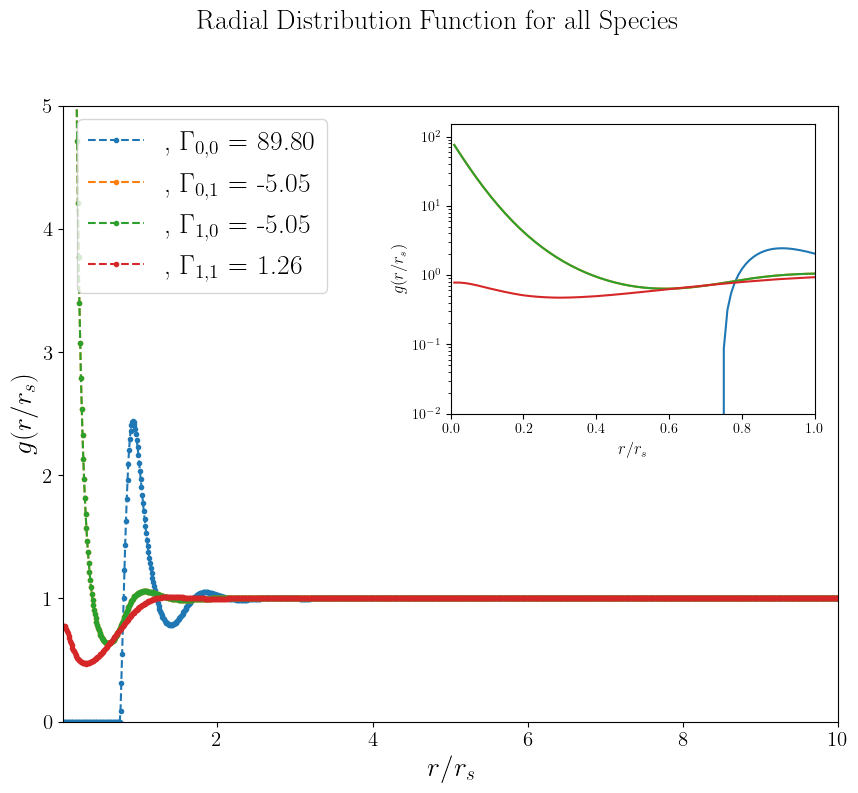

In [56]:
atom2.hnc.plot_g_all_species()

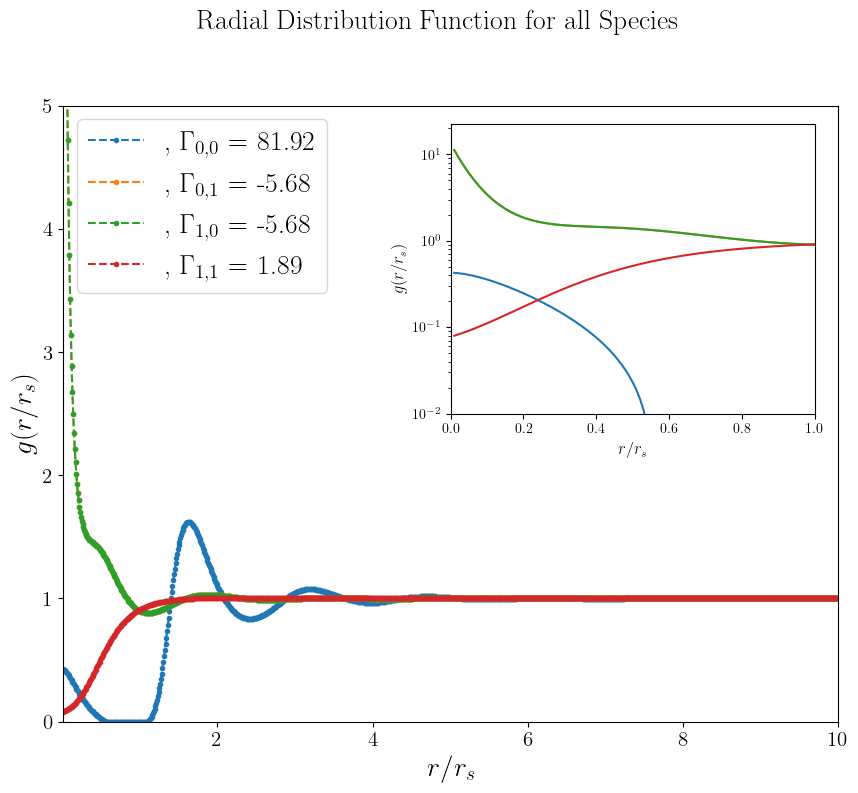

In [96]:
atom3.hnc.plot_g_all_species()

### Comparison to QMD

In [40]:
MD_data = read_csv("../../RDFs/V_5.0eV_rs2.82_VASP.txt",  header=0, delim_whitespace=True)
MD_data.columns=['r','g']
MD_data

,r,g
0,1.4378,0.000000
1,1.4963,0.007183
2,1.5317,0.060301
3,1.6003,0.259140
4,1.6665,0.596870
5,1.7141,0.795780
6,1.7514,0.946120
7,1.7951,1.068700
8,1.8241,1.151900
9,1.8616,1.205000


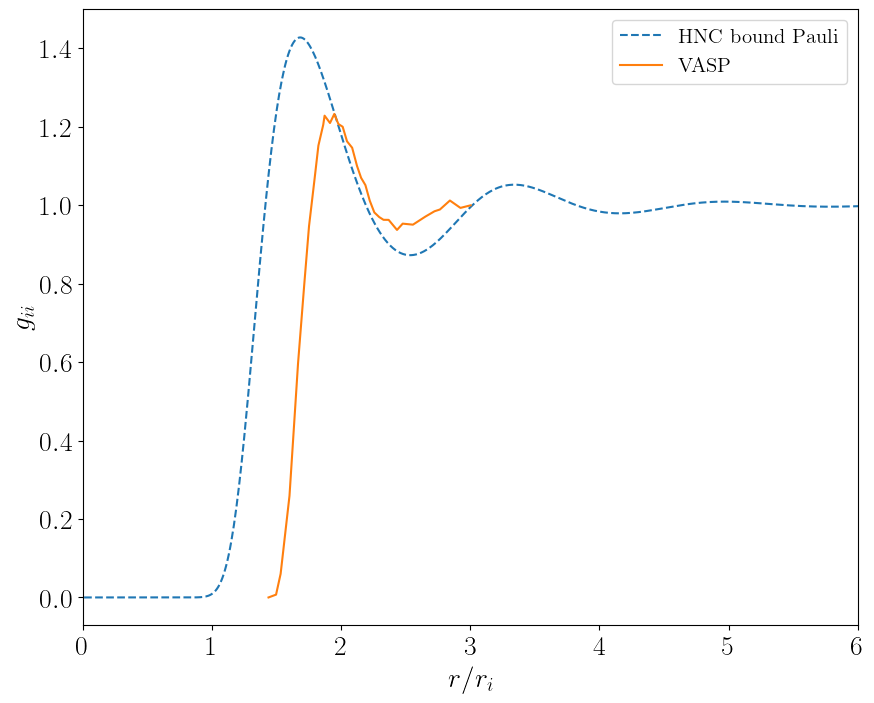

In [48]:
# AA_data = read_csv("/home/zach/plasma/atoMEC/examples/density.csv", delim_whitespace=True, header=0)

fig, ax = plt.subplots(figsize=(10,8))
# nf_0 = Zbar/(4/3*np.pi*atom.qsp.ri**3)
# ax.plot(AA_data['r[a_0]'], np.array(AA_data['n[unbound]'])/nf_0,'k.' ,label="AA" )
# ax.plot(atom_2e.hnc.r_array*atom_2e.qsp.ri, atom_2e.hnc.h_r_matrix[0,0]+1,'--', label='2 electron SVT ')
# ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[0,0]+1,'--', label='Ashcroft Pseudopotential')
ax.plot(atom2.hnc.r_array, atom2.hnc.h_r_matrix[0,0]+1,'--', label='HNC bound Pauli')
# ax.plot(atom3.hnc.r_array, atom3.hnc.h_r_matrix[0,0]+1,'--', label='Lado bound Paulo')
# ax.plot(atom_long.hnc.r_array, atom_long.hnc.h_r_matrix[0,0]+1,'-.', label='1 electron SVT-long ')
# ax.plot(atom_oz.hnc.r_array, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='1 electron OZ ')
# ax.plot(atom.hnc.r_array, atom_oz.onlyion_hnc.h_r_matrix[0,0]+1,'--', label='Only Ion')
ax.plot(MD_data['r'], MD_data['g'], label='VASP')

# ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='my OZ CHNC')

ax.set_xlim(0,6)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=2)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=15)

In [54]:
atom2.hnc.r_array[np.argmin( np.abs( atom2.hnc.h_r_matrix[0,0]+1 -0.0001 ))], atom2.hnc.r_array[np.argmax( atom2.hnc.h_r_matrix[0,0]+1)]

(0.86, 1.68)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


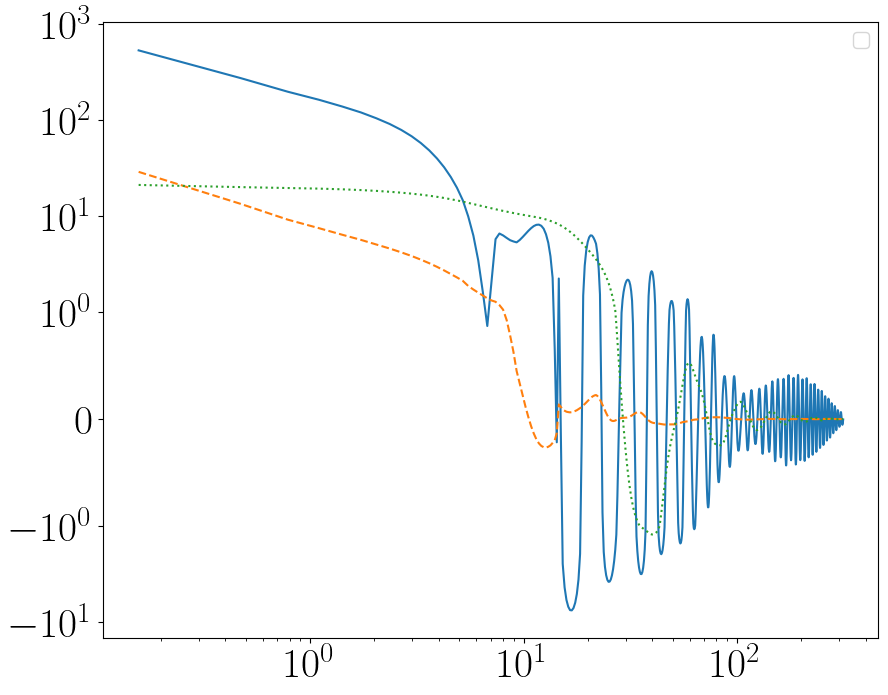

In [57]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(atom2.hnc.k_array, atom2.hnc.c_s_k_matrix[0,0],'-' )
ax.plot(atom2.hnc.k_array, atom2.hnc.c_s_k_matrix[1,0],'--' )
ax.plot(atom2.hnc.k_array, atom2.hnc.c_s_k_matrix[1,1],':' )

ax.set_yscale('symlog',linthresh=1)
ax.set_xscale('log')
ax.legend(fontsize=14)

(0.0, 20.0)

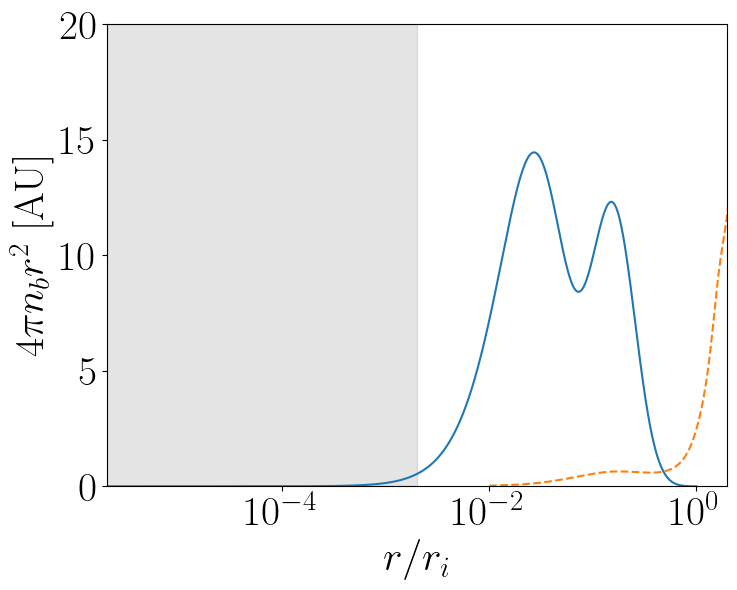

In [53]:
bound_file = "/home/zach/plasma/hnc/TCCW/data/Al_rs_3.000_T_1.000e+00eV.csv"
AA_data = read_csv(bound_file, delim_whitespace=True, header=0)
AA_r_AU_full = np.array(AA_data['r[a_0]'])
AA_nb_AU_full = np.array(AA_data['n(bound)'])

# Only use some values for speed
min_r_to_use = 0.2*atom.hnc.r_array[0]*atom.qsp.ri # in AU
indcs = np.where(AA_r_AU_full > min_r_to_use)
AA_r_AU = AA_r_AU_full[indcs]
AA_nb_AU = AA_nb_AU_full[indcs]

# Plot bound states
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(AA_r_AU_full/atom.qsp.ri, 4*π*AA_nb_AU_full*AA_r_AU_full**2)
ax.plot(atom2.hnc.r_array, 4*π*(atom2.hnc.r_array*atom2.qsp.ri)**2*(atom2.hnc.h_r_matrix[0,1]+1)*(atom2.hnc.rho[1]/atom2.qsp.ri**3),'--', label='HNC bound Pauli')
ax.axvspan(AA_r_AU_full[0]/atom.qsp.ri, min_r_to_use/atom.qsp.ri, color='k', alpha=0.1)
ax.set_xlabel(r'$r/r_i$')
ax.set_ylabel(r'$4 \pi n_b r^2$ [AU]')
ax.set_xscale('log')
ax.set_xlim(np.min(AA_r_AU_full/atom.qsp.ri), 2*np.max(AA_r_AU_full/atom.qsp.ri))
ax.set_ylim(0, 20)


## Born Green Viscocity
See [Morioka 2004](https://www.sciencedirect.com/science/article/pii/S0022309304003692)

\begin{align}
η = f_{BG} \frac{2 \pi}{15} \left(\frac{M}{RT} \right)^{1/2} \frac{n^2}{N_a} \int^\infty_0 g(r) \frac{d\phi}{dr}r^4 dr
\end{align}
Resulting units is Pa s


In [ ]:
from scipy.integrate import simpson

def get_ηBG(plasma):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    ##
    fig, ax = plt.subplots()
    ax.plot(r_array, dφdr*r_array**4)
    ###
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    return η

η_SI = get_ηBG(atom2)*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
print(f"SI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
print(f"CGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")

# Plot Fixed Neutrality Issue βu_eff

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

atom.hnc.invert_HNC_OZ([1])
βu_r_raw = atom.hnc.βueff_r_matrix[0,0]
βu_r_raw_fix1 = βu_r_raw - βu_r_raw[-1]
βu_r_raw_fix2 = βu_r_raw - (βu_r_raw[-1]*atom.hnc.r_array[-1])/atom.hnc.r_array
tapering_func = lambda r: np.exp( -0.02*r**2/(5-r))
βu_r_raw_fix3 = βu_r_raw*tapering_func(atom.hnc.r_array)
βu_r_raw_fix4 = βu_r_raw_fix1*tapering_func(atom.hnc.r_array)


fig, axs  = plt.subplots(1,2,figsize=(20,8))
yukawa_matrix = (atom_long.hnc.Gamma[:,:,np.newaxis]/atom_long.hnc.r_array * np.exp(-atom_long.hnc.r_array*atom_long.qsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]

axs[0].set_title(r"$\beta u$")
axs[0].plot(atom.hnc.r_array, βu_r_raw,'k--', label='Raw')
axs[0].plot(atom_long.hnc.r_array, atom_long.hnc.βueff_r_matrix[0,0],'k-.', label='Long')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix1, label=r'Constant Shift to $\beta u_{eff}$')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix2 , label=r'Subtraction of Coulomb directly')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix3, label=r'Tapered raw')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix4, label=r'Tapered shifted')
axs[0].plot(atom_long.hnc.r_array, yukawa_matrix[0,0],'-.', label='Yukawa')

axs[1].set_title(r"$F$")
dudx = lambda u: -(u[1:]-u[:-1])/atom.hnc.del_r
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw),'k--', label='Raw')
axs[1].plot(atom_long.hnc.r_array[1:], dudx(atom_long.hnc.βueff_r_matrix[0,0]),'k-.', label='Long')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix1), label=r'Constant Shift to $\beta u_{eff}$')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix2) , label=r'Subtraction of Coulomb directly')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix3), label=r'Tapered raw ')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix4), label=r'Tapered shifted')
βueff_r_header="r/r_i \t\t\t βuii_eff(r/r_i)"
np.savetxt("./fits/{0}_βu_eff_raw.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw]).T, header=βueff_r_header)
np.savetxt("./fits/{0}_βu_eff_shifted.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw_fix1]).T, header=βueff_r_header)
np.savetxt("./fits/{0}_βu_eff_tapered.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw_fix3]).T, header=βueff_r_header)
np.savetxt("./fits/{0}_βu_eff_shifted_tapered.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw_fix4]).T, header=βueff_r_header)

axs[1].set_xlim(4,10)

for ax in axs:
    ax.set_yscale('symlog',linthresh=1e-8)

    ax.legend(fontsize=15)


### Plot $\beta u^{eff}$

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')
def make_gij(ax):
    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[0,0]+1,'-', label=r'$g_{ii}$')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[0,1]+1,'--', label=r'$g_{ei}$')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[1,1]+1,':', label=r'$g_{ee}$')

    # ax.set_yscale('symlog', linthresh=5)
    ax.set_xlim(0,10)
    ax.set_ylim(-0.05,5)

    ax.set_xlabel(r"$r$ [AU]")#, fontsize=25)
    ax.set_ylabel(r"$g_{ij}$")#, fontsize=25)
    ax.legend()

fig, ax = plt.subplots()
make_gij(ax)
plt.savefig("gij_Al1.png")

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

atom.hnc.invert_HNC_OZ([1])
def make_βu(ax):
    yukawa_matrix = (atom.hnc.Gamma[:,:,np.newaxis]/atom.hnc.r_array * np.exp(-atom.hnc.r_array*atom.qsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
    coulomb_matrix = (atom.hnc.Gamma[:,:,np.newaxis]/atom.hnc.r_array) [:-1,:-1]

    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.βueff_r_matrix[0,0],'-', label='HNC Inversion')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, yukawa_matrix[0,0],'-.', label='Yukawa')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, coulomb_matrix[0,0],'--', label='Coulomb')

    ax.set_yscale('symlog', linthresh=1)

    ax.set_xlabel(r"$r$ [AU]")#, fontsize=25)
    ax.set_ylabel(r"$\beta u_{\rm eff}$")#, fontsize=25)
    ax.legend()

fig, ax = plt.subplots()
make_βu(ax)
plt.savefig("βu_Al1.png")

### Now Plot Both Together

In [ ]:
plt.style.use('~/plasma/mpl_styles/paper.mplstyle')

fig, axs = plt.subplots(1,2, figsize=(18,8))

make_gij(axs[0])
make_βu(axs[1])
plt.tight_layout()
plt.savefig("βu_gij_Al1.png")


# Run Many Cases

In [ ]:

for tccw_case in tccw_cases[6:]:
    α = 0.1
    case_converged=False
    case_attempts=0
    case_num= tccw_case[' ']
    case_id = tccw_case['Case ID']
    ni_cc = tccw_case['Number Density [N/cc]']
    Te_eV = tccw_case['Temperature [eV]']
    Ti_eV = Te_eV
    Z = tccw_case['Atomic Number']
    Zbar = tccw_case['Zbar (TFDW)']
    P_GP_AU  = tccw_case['p (Bar)']/AU_to_bar
    A = tccw_case['Atomic Weight [a.u.]']
    r_s_cc = tccw_case['Wigner-Seitz Radius [cm]']
    r_c = tccw_case['Average-Bound Radius [cm]']/r_s_cc
    if r_c>1:
        r_c=1e-5
    print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
    print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te_eV, ni_cc, r_c))
    print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 1e3*ni_cc*m_p*A ))
    print("P  = {0:.3e} [bar] = {1:.3e} [AU]".format(P_GP_AU*AU_to_bar, P_GP_AU))
    
    α = 1
    converged=False
    while not converged:
        atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, 
                     βu_options = {'add_bridge':True}, 
                     qsp_options={'r_c':r_c},
                     hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000},
                     hnc_solve_options={'alpha_Picard':α})
        atom.run_hnc()
        if atom.hnc.newton_succeed==True:
            converged=True
        else:
            α*=0.5
            
    atom.get_cp()

# Only Ion

In [ ]:
atom.run_onlyion_hnc()

In [ ]:
atom.onlyion_hnc.plot_species_convergence_g()

In [ ]:
# c_s_k_guess = atom.hnc.c_s_k_matrix.copy()*0
c_s_k_guess[0,0] = atom.onlyion_hnc.c_s_k_matrix[0,0]*0.


atom.run_hnc(c_s_k_guess = c_s_k_guess)


# Make atom

In [ ]:
Zbar_list  = np.linspace(3,Zbar, num=100)
# Zbar_list = [1,3]
atom_list= []
for i, Zbar_i in enumerate(Zbar_list):
    print("Zbar = {0:.3f}".format( Zbar_i ))
    
    atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar_i, 
                 βu_options = {'add_bridge':True}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':10},
                 hnc_solve_options={'alpha_Picard':0.5})
    if i>=1:
        Z2_matrix = [[Zbar_list[i]]]
        guess_2 = 
        c_s_k_guess = atom_list[-1].hnc.c_s_k_matrix
        c_s_k_guess[0,0] *= (Zbar_list[i]/Zbar_list[i-1])**2 
        c_s_k_guess[0,1] *= (Zbar_list[i]/Zbar_list[i-1])**1 
        c_s_k_guess[1,0] *= (Zbar_list[i]/Zbar_list[i-1])**1
#         c_s_k_guess[0,0] *= 0
    else:
        c_s_k_guess *=0
    atom.run_hnc(c_s_k_guess=c_s_k_guess)
    atom_list.append( atom )

In [ ]:
fig, axs = plt.subplots(2, 2, facecolor='w', figsize=(10,8) )

atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix-atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 
atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix/atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 

for i in range(2):
    for j in range(2):
        for k, atom in enumerate(atom_list):
            color = plt.cm.viridis(k/len(atom_list))
            Z_factor = (Zbar_list[0]/Zbar_list[k])**-1
            axs[i, j].plot(atom.hnc.r_array, atom.hnc.c_s_k_matrix[i,j], '--',label= "Zbar", color= color)
            axs[i, j].plot(atom.hnc.r_array, Z_factor*atom_list[0].hnc.c_s_k_matrix[i,j],'.', label= "Zbar", color= color)
#             axs[i, j].plot(atom.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=2")
#             axs[i, j].plot(atom.hnc.r_array, atom6.hnc.c_s_k_matrix[i,j], label= "Zbar=6")
#         axs[i, j].plot(atom2.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j]-atom1.hnc.c_s_k_matrix[i,j], label= "Zbar=2/1")
#         axs[i, j].plot(atom2.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j]-atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=3/2")
#         axs[i, j].plot(atom2.hnc.r_array, atom3_guess[i,j] , 'k--', label= "Zbar=3 (guess)")
        
#         axs[i, j].plot(atom3.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j],'k', label= "Zbar=3")
#         axs[i, j].plot(atom100.hnc.r_array, atom80.hnc.c_s_k_matrix[i,j]-100/80*atom100.hnc.c_s_k_matrix[i,j], label= "80/100 eV")
#         axs[i, j].plot(atom100.hnc.r_array, atom60.hnc.c_s_k_matrix[i,j], label= "60 eV")
         
#         axs[i, j].plot(atom100.hnc.r_array, T_rescale[i,j]*atom100.hnc.c_s_k_matrix[i,j], label= "rescaled 100 eV")
        
        axs[i,j].set_xscale('log')
#         axs[i, j].set_yscale('symlog', linthresh=0.1)
#         axs[i, j].legend()
        
plt.tight_layout()

In [ ]:
atom.get_cp(ε_derivative=1e-6, ε_table=1e-1, N_table= 2 )

In [ ]:
fig, ax = plt.subplots()

# ax.plot(atom.hnc.r_array, atom.hnc.βueff_r_matrix[0,0])
ax.plot(atom.hnc.r_array, atom.hnc.h_r_matrix[0,0]+1)
# ax.set_yscale('symlog', linthresh=1)

###### Hydrogen H1

c_p = 1.667e+08 [J/m^3/K] = 1.667e+09 [erg/cc/K]


c_p^ideal = 2.064e+07 [J/m^3/K] = 2.064e+08 [erg/cc/K]

c_v = 1.229e+08 [J/m^3/K] = 1.229e+09 [erg/cc/K]


γ = cp/cv = 1.357e+00

###### Aluminum Al1

c_p = 5.560e+06 [J/m^3/K] = 5.560e+07 [erg/cc/K]

c_p^ideal = 2.081e+06 [J/m^3/K] = 2.081e+07 [erg/cc/K]

c_v = 3.559e+06 [J/m^3/K] = 3.559e+07 [erg/cc/K]

c_p_over_nkB = 6.678

c_v_over_nkB = 4.275

γ = cp/cv = 1.562e+00

##### Carbon C1

c_p = 1.005e+09 [J/m^3/K] = 1.005e+10 [erg/cc/K]

c_p^ideal = 1.729e+07 [J/m^3/K] = 1.729e+08 [erg/cc/K]

c_v = 7.410e+08 [J/m^3/K] = 7.410e+09 [erg/cc/K]

γ = cp/cv = 1.357e+00

##### Copper Cu1
c_p = 6.829e+07 [J/m^3/K] = 6.829e+08 [erg/cc/K]

c_p^ideal = 2.930e+06 [J/m^3/K] = 2.930e+07 [erg/cc/K]

c_v = 4.460e+07 [J/m^3/K] = 4.460e+08 [erg/cc/K]

γ = cp/cv = 1.531e+00

In [ ]:
# Compare to Ichimaru
n_AU = ni_cc * (1e2*aB)**3
E_over_nkBT = atom.U/( Te*N )
P_over_nkBT = atom.P/(Te*n_AU)
c_p_over_nkB = C_p_AU/N #c_p_SI_vol/k_B/(ni_cc*1e6)
E_over_nkBT, P_over_nkBT, c_p_over_nkB  

In [ ]:
# 2x2
#(16.078004224152146, 7.958852940677674, 20.391840227664225)
# 3x3
#(17.29156071613095, 9.41653222069282, 19.954770080816058)
# 4x4
#(17.29156071613095, 9.41653222069282, 20.31577883096223)
# 6x6
#(17.29156071613095, 9.41653222069282, 20.341775951597302)



In [ ]:
#cp units are J/K/m^3

In [ ]:
c_p_SI_vol *J_to_erg*1e-6 # from J/K/m^3 to erg/K/cc

In [ ]:
(c_p_over_nkB*ni_cc * k_B*1e6)/1e8 # in erg/

In [ ]:
# Ideal
# (1.503495387998133, 1.0020009999999997, 2.5033223241241656)


# βu_eff matching

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [ ]:
atom = atom_highres

In [ ]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

In [ ]:
luke_r

In [ ]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, 5)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()